In [97]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import Trader

self= Trader.Trader()
symbol= 'ETHUSD'
tf= 'M30'
bars_window= 200
n_std= 2

start_date= datetime(2018, 1, 30)
end_date= datetime.now()

df_data= self.get_ohlc_range(symbol, tf, start_date, end_date)

Updating balance and positions...
Ready to trade


In [98]:
df_data.head()

time   open   high    low  close  \
time                                                                  
2018-06-29 02:30:00 2018-06-29 02:30:00  418.0  418.5  417.0  417.0   
2018-06-29 03:00:00 2018-06-29 03:00:00  417.0  421.5  417.0  419.0   
2018-06-29 03:30:00 2018-06-29 03:30:00  419.0  421.5  418.0  420.5   
2018-06-29 04:00:00 2018-06-29 04:00:00  421.0  422.0  417.5  419.0   
2018-06-29 04:30:00 2018-06-29 04:30:00  419.0  419.0  417.5  417.5   

                     tick_volume  spread  real_volume  
time                                                   
2018-06-29 02:30:00           11     550            0  
2018-06-29 03:00:00          140     450            0  
2018-06-29 03:30:00          144     450            0  
2018-06-29 04:00:00           89     450            0  
2018-06-29 04:30:00           72     450            0

In [68]:
df_data['roll_close_mean']= df_data['close'].rolling(bars_window).mean()
df_data['roll_close_std']= df_data['close'].rolling(bars_window).std()

df_data['up_band']= df_data['roll_close_mean'] + n_std*df_data['roll_close_std']
df_data['down_band']= df_data['roll_close_mean'] - n_std*df_data['roll_close_std']

In [69]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x= df_data.index, open= df_data['open'], high= df_data['high'], low= df_data['low'], close= df_data['close']))

fig.update_layout(height= 750, margin= dict(l=50, r=50, t=30, b=30), template='seaborn')
fig.show()

In [70]:
fig.add_trace(go.Scatter(x= df_data.index, y= df_data['up_band']))
fig.add_trace(go.Scatter(x= df_data.index, y= df_data['down_band']))

fig.show()

In [71]:
open_position = 0
trades = []
position_size = 100

dict_map= {j:i for i, j in enumerate(df_data.columns)}

In [72]:
for row in df_data.values:
    if open_position == 0 and row[dict_map['close']] < row[dict_map['down_band']]:
        open_position = 1
        trades+= [{'time': row[dict_map['time']], 'price': row[dict_map['close']], 'down_band': row[dict_map['down_band']], 'side': 'Long', 'position_size': position_size}]

    elif open_position == 1 and row[dict_map['close']] > row[dict_map['up_band']]:
        open_position = 0
        trades+= [{'time': row[dict_map['time']], 'price': row[dict_map['close']], 'up_band': row[dict_map['up_band']], 'side': 'Short', 'position_size': position_size}]

In [73]:
df_trades= pd.DataFrame(trades)

df_buy= df_trades[df_trades['side'] == 'Long']
df_sell= df_trades[df_trades['side'] == 'Short']

df_trades['return %'] = df_trades['price']/df_trades['price'].shift(1)
df_trades['return $'] = df_trades['position_size']*df_trades['return %'] - 100
df_trades.loc[df_trades['side'] == 1, ['return %', 'return $']] = 0


In [74]:
fig.add_trace(go.Scatter(x=df_buy['time'], y= df_buy['price'], mode= 'markers', marker_color='#11dd11', marker_size=8))
fig.add_trace(go.Scatter(x=df_sell['time'], y=df_sell['price'], mode= 'markers', marker_color='#dd2222', marker_size=8 ))

In [ ]:
len(df_trades[df_trades['side'] == 'Short'])

27

Result


this strategy had a return of 66.36%


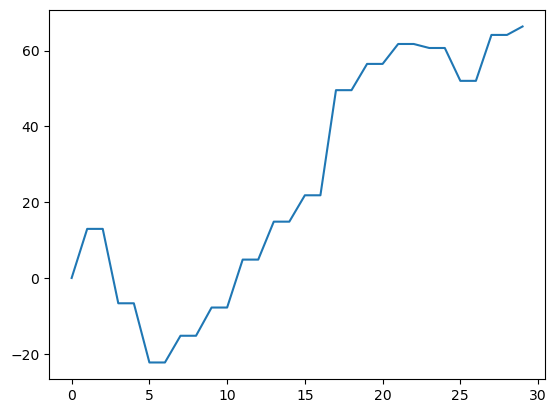

In [47]:
df_trades['return $'].cumsum().plot()
return_perc = (df_trades['return $'].sum()/position_size) * 100

print(f'this strategy had a return of {return_perc:.2f}%')

Function

In [107]:
def boll_bands(symbol: str, bars_window: int, n_std: float, position_size: int, timeframe: str, start_date: str, end_date= datetime.now(), fig= None):
    
    start= pd.to_datetime(start_date).to_pydatetime()
    end_date= datetime.now()

    open_position = 0
    trades = []
    
    df_data= self.get_ohlc_range(symbol, timeframe, start, end_date)

    df_data['roll_close_mean']= df_data['close'].rolling(bars_window).mean()
    df_data['roll_close_std']= df_data['close'].rolling(bars_window).std()

    df_data['up_band']= df_data['roll_close_mean'] + (n_std)*df_data['roll_close_std']
    df_data['down_band']= df_data['roll_close_mean'] - (n_std)*df_data['roll_close_std']

    for row in df_data.values:
        if open_position == 0 and row[dict_map['close']] < row[dict_map['down_band']]:
            open_position = 1
            trades+= [{'time': row[dict_map['time']], 'price': row[dict_map['close']], 'up_band': row[dict_map['up_band']], 'down_band': row[dict_map['down_band']], 'side': 'Long', 'position_size': position_size}]

        elif open_position == 1 and row[dict_map['close']] > row[dict_map['up_band']]:
            open_position = 0
            trades+= [{'time': row[dict_map['time']], 'price': row[dict_map['close']], 'up_band': row[dict_map['up_band']], 'down_band': row[dict_map['down_band']], 'side': 'Short', 'position_size': position_size}]

    df_trades= pd.DataFrame(trades)
    df_trades.set_index("time", inplace= True)
    df_trades['return %'] = df_trades['price']/df_trades['price'].shift(1)
    df_trades['return $'] = df_trades['position_size']*df_trades['return %'] - position_size
    df_trades.loc[df_trades['side'] == 'Long', ['return %', 'return $']] = 0
    df_trades['return $'].cumsum().plot(label=f"bars={bars_window}, std={n_std}, tf={timeframe}")

    return_perc = (df_trades['return $'].sum()/position_size) * 100
    n_trades= len(df_trades[df_trades['side'] == 'Short'])
    print(f'Strategy (bars= {bars_window}, number of std= {n_std}, timeframe= {timeframe}, position size= {position_size}) had a return of {return_perc:.2f}%, with a number of {n_trades} trades')

    return df_trades, return_perc

Strategy (bars= 100, number of std= 2, timeframe= M15, position size= 100) had a return of 118.80%, with a number of 682 trades
Strategy (bars= 100, number of std= 2, timeframe= M30, position size= 100) had a return of 10.78%, with a number of 317 trades
Strategy (bars= 100, number of std= 3, timeframe= M15, position size= 100) had a return of 21.42%, with a number of 319 trades
Strategy (bars= 100, number of std= 3, timeframe= M30, position size= 100) had a return of 107.15%, with a number of 151 trades
Strategy (bars= 150, number of std= 2, timeframe= M15, position size= 100) had a return of 49.85%, with a number of 436 trades
Strategy (bars= 150, number of std= 2, timeframe= M30, position size= 100) had a return of 78.15%, with a number of 226 trades
Strategy (bars= 150, number of std= 3, timeframe= M15, position size= 100) had a return of 49.96%, with a number of 224 trades
Strategy (bars= 150, number of std= 3, timeframe= M30, position size= 100) had a return of 158.26%, with a nu

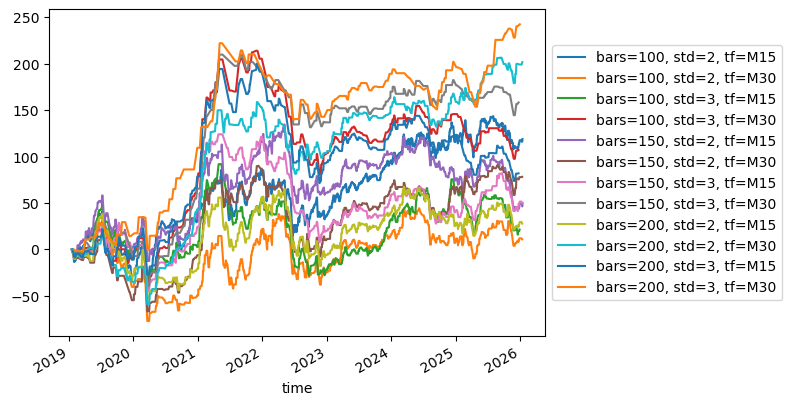

In [122]:
positive_return = 0
negative_return = 0
neutral_return = 0
cutoff = 50 


bars_windows = [100, 150, 200]
stds = [2, 3]
timeframes = ['M15', 'M30']

for bars in bars_windows:
    for std in stds:
        for tf in timeframes:
            df_trades, return_perc = boll_bands('ETHUSD', bars, std, 100, tf, '2019-01-13')

            if return_perc > cutoff:
                positive_return+= 1
            elif return_perc < (cutoff - 50):
                negative_return+= 1
            else:
                neutral_return+= 1

print(f"positives: {positive_return}, negatives: {negative_return}, neutral: {neutral_return}")

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

In [ ]:
boll_bands('ETHUSD', 200, 2, 100, 'M30', '2025-01-30')